In [1]:
import pandas as pd
from src.parameters import CM_PER_PIXEL
from src.load_data import flip_y

hex_coords = pd.read_csv("../Raw-Data/hex_center_coordinates_IM-1594_07252023.csv")
hex_coords[["x", "y"]] = (
    flip_y(
        hex_coords[["x", "y"]].to_numpy(),
        hex_coords[["x", "y"]].max().to_numpy(),
    )
    * CM_PER_PIXEL
)
hex_coords

,hex_label,x,y
0,1,100.969331,0.000000
1,2,49.300843,94.482888
2,3,150.852911,95.437295
3,4,100.870170,10.551121
4,5,109.283261,15.906216
5,6,92.357917,15.747148
6,7,109.184100,26.457337
7,8,92.258755,26.298269
8,9,117.597191,31.812432
9,10,100.671847,31.653364


In [2]:
from src.load_data import load_data


position_info, spikes, multiunit_firing_rate, multiunit_HSE_times = load_data(
    position_file_name="/Users/edeno/Documents/GitHub/tk_decoding/Raw-Data/IM-1594_07252023_position.csv",
    spike_file_name="/Users/edeno/Documents/GitHub/tk_decoding/Raw-Data/IM-1594_07252023_spikesWithPosition.csv",
)

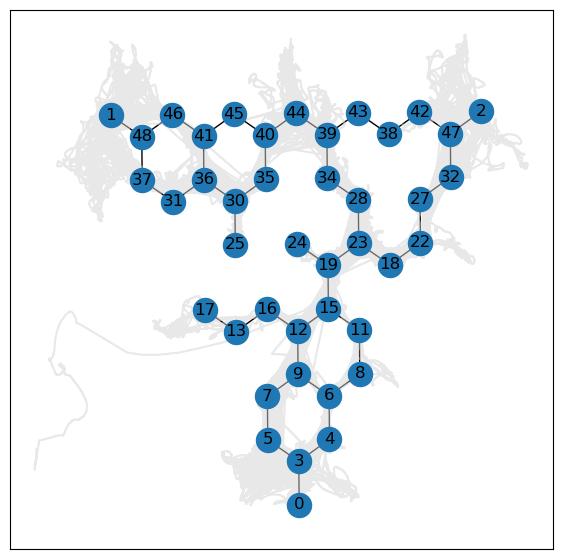

In [3]:
from track_linearization import make_track_graph, plot_track_graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def hex_occupied(hex_label, position_info, hex_radius=5.5):
    hex_center = hex_coords.set_index("hex_label").loc[hex_label]
    return np.any(
        np.linalg.norm(position_info[["x", "y"]] - hex_center[["x", "y"]], axis=1)
        < hex_radius
    )


hex_radius = 5.5

valid_nodes = [
    int(row.hex_label)
    for row in hex_coords.itertuples(index=False)
    if hex_occupied(row.hex_label, position_info, hex_radius=hex_radius)
]

edges = []
for hex_label, row in hex_coords.set_index("hex_label").loc[valid_nodes].iterrows():
    for hex_label2, row2 in (
        hex_coords.set_index("hex_label").loc[valid_nodes].iterrows()
    ):
        if hex_label == hex_label2:
            continue
        if np.linalg.norm(row[["x", "y"]] - row2[["x", "y"]]) < hex_radius * 2:
            edges.append((int(hex_label), int(hex_label2)))

track_graph = make_track_graph(hex_coords[["x", "y"]].to_numpy(), np.array(edges) - 1)
track_graph.remove_nodes_from(list(nx.isolates(track_graph)))

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info["x"], position_info["y"], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

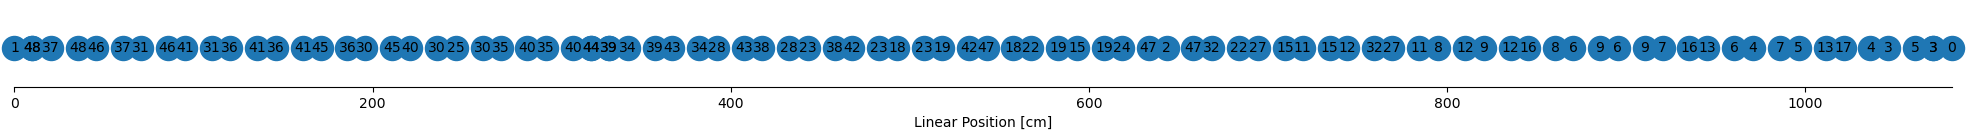

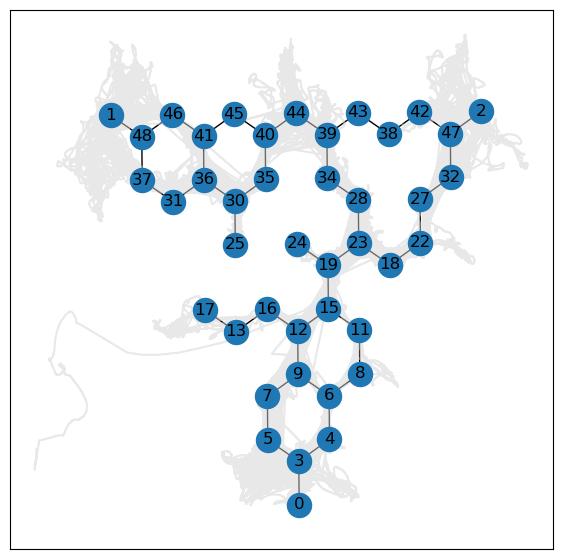

In [4]:
from track_linearization import plot_graph_as_1D
from scipy.ndimage import label

linear_edge_order = list(nx.traversal.edge_bfs(track_graph, source=1))
is_connected_component = ~(
    np.abs(np.array(linear_edge_order)[:-1, 1] - np.array(linear_edge_order)[1:, 0]) > 0
)
linear_edge_spacing = ~is_connected_component * 15.0

fig, ax = plt.subplots(figsize=(25, 1))
plot_graph_as_1D(track_graph, linear_edge_order, linear_edge_spacing, ax=ax)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info["x"], position_info["y"], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

In [5]:
from track_linearization import get_linearized_position

linear_position_info = get_linearized_position(
    position_info[["x", "y"]].to_numpy(),
    track_graph,
    edge_order=linear_edge_order,
    edge_spacing=linear_edge_spacing,
    use_HMM=False,
)

linear_position_info

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,1021.355245,16,75.135087,47.241444
1,1021.355245,16,75.135087,47.241444
2,1021.355245,16,75.135087,47.241444
3,1021.355245,16,75.135087,47.241444
4,1021.355245,16,75.135087,47.241444
...,...,...,...,...
1613512,1075.494511,0,100.909581,6.357680
1613513,1075.494511,0,100.909581,6.357680
1613514,1075.494511,0,100.909581,6.357680
1613515,1075.494511,0,100.909581,6.357680


In [6]:
# Assume center_node is the center node
closeness_centrality = nx.centrality.closeness_centrality(
    track_graph, distance="weight"
)

# Find the node with the highest closeness centrality
center_node = max(closeness_centrality, key=closeness_centrality.get)

# Initialize lists to store the centripetal and centrifugal edges
centripetal_edges = []
centrifugal_edges = []

# Classify each edge direction as centripetal or centrifugal
for u, v in track_graph.edges():
    if closeness_centrality[u] < closeness_centrality[v]:
        centripetal_edges.append((u, v))
    else:
        centrifugal_edges.append((u, v))

    if closeness_centrality[v] < closeness_centrality[u]:
        centripetal_edges.append((v, u))
    else:
        centrifugal_edges.append((v, u))


centrifugal_edges

[(3, 0),
 (48, 1),
 (47, 2),
 (4, 3),
 (5, 3),
 (6, 4),
 (7, 5),
 (8, 6),
 (9, 6),
 (9, 7),
 (11, 8),
 (12, 9),
 (15, 11),
 (15, 12),
 (12, 16),
 (16, 13),
 (13, 17),
 (19, 15),
 (18, 22),
 (23, 18),
 (23, 19),
 (19, 24),
 (22, 27),
 (23, 28),
 (30, 25),
 (27, 32),
 (28, 34),
 (35, 30),
 (30, 36),
 (36, 31),
 (31, 37),
 (32, 47),
 (34, 39),
 (40, 35),
 (41, 36),
 (48, 37),
 (38, 42),
 (43, 38),
 (39, 43),
 (39, 44),
 (44, 40),
 (40, 45),
 (45, 41),
 (41, 46),
 (47, 42),
 (46, 48)]

In [7]:
def get_edge_direction_mapping(node1, node2, centripetal_edges, centrifugal_edges):

    if (node1, node2) in centripetal_edges and (node2, node1) in centrifugal_edges:
        return {
            (node1, node2): "centripetal (towards center)",
            (node2, node1): "centrifugal (away from center)",
        }
    elif (node1, node2) in centrifugal_edges and (node2, node1) in centripetal_edges:
        return {
            (node1, node2): "centrifugal (away from center)",
            (node2, node1): "centripetal (towards center)",
        }
    else:
        print("error")

In [8]:
position = position_info[["x", "y"]].to_numpy()

node_positions = nx.get_node_attributes(track_graph, "pos")

array('centripetal', dtype='<U11')

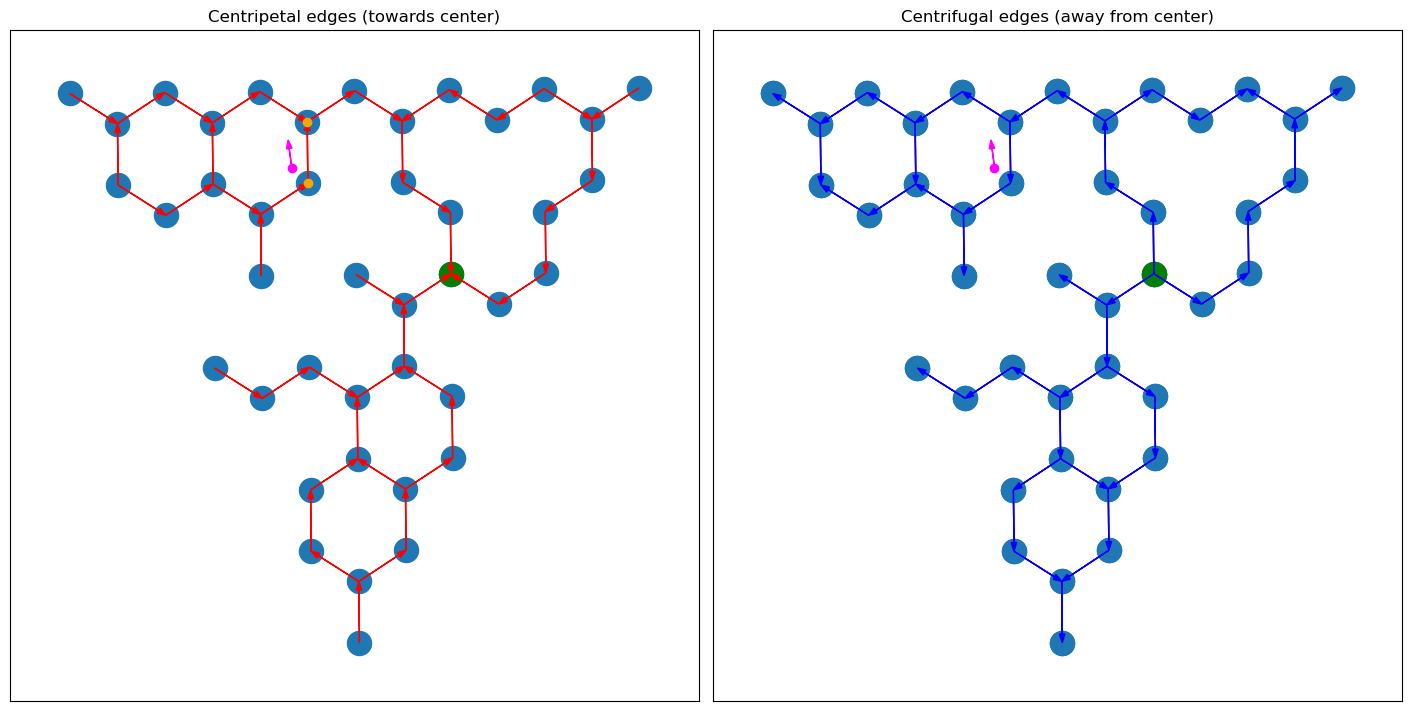

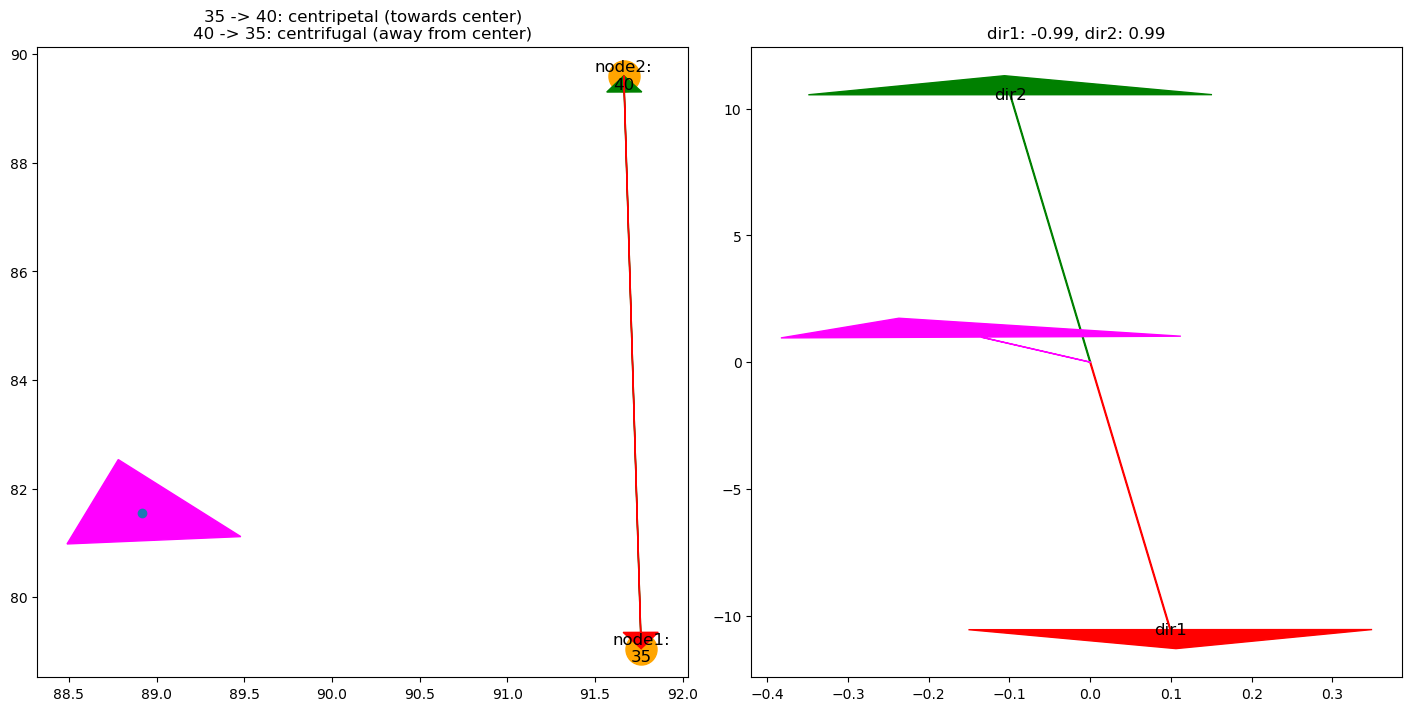

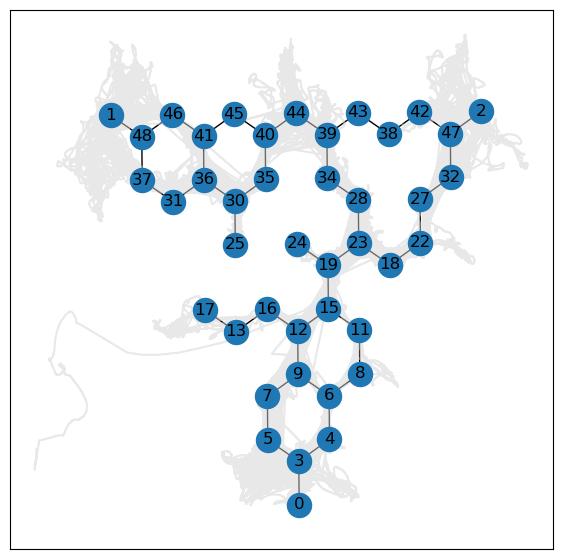

In [9]:
from sklearn.metrics.pairwise import cosine_similarity


time_ind = 288_000

# pos_angle = np.arctan2(
#     position_info.iloc[time_ind]["y"] - position_info.iloc[time_ind - 1]["y"],
#     position_info.iloc[time_ind]["x"] - position_info.iloc[time_ind - 1]["x"],
# )

head_direction = position_info["head_direction"].iloc[time_ind]

fig, axes = plt.subplots(
    1, 2, figsize=(14, 7), sharex=True, sharey=True, constrained_layout=True
)
# Draw the nodes of the graph
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[0])
nx.draw_networkx_nodes(
    track_graph,
    pos=node_positions,
    nodelist=[center_node],
    node_color="green",
    ax=axes[0],
)
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color="grey", ax=axes[0])

for u, v in centripetal_edges:
    axes[0].arrow(
        node_positions[u][0],
        node_positions[u][1],
        node_positions[v][0] - node_positions[u][0],
        node_positions[v][1] - node_positions[u][1],
        color="red",
        head_width=1,
        zorder=10,
        length_includes_head=True,
    )
axes[0].set_title("Centripetal edges (towards center)")


axes[0].scatter(
    position_info.iloc[time_ind]["x"],
    position_info.iloc[time_ind]["y"],
    color="magenta",
    zorder=10,
)
node1, node2 = list(track_graph.edges)[
    int(linear_position_info.iloc[time_ind].track_segment_id)
]

axes[0].scatter(*track_graph.nodes[node1]["pos"], color="orange", zorder=15)
axes[0].scatter(*track_graph.nodes[node2]["pos"], color="orange", zorder=15)

axes[0].arrow(
    position_info.iloc[time_ind - 1]["x"],
    position_info.iloc[time_ind - 1]["y"],
    5 * np.cos(head_direction),
    5 * np.sin(head_direction),
    color="magenta",
    head_width=1,
    length_includes_head=True,
    zorder=10,
)


# Draw the centripetal edge direction
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])

nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])
nx.draw_networkx_nodes(
    track_graph,
    pos=node_positions,
    nodelist=[center_node],
    node_color="green",
    ax=axes[1],
)
nx.draw_networkx_edges(
    track_graph,
    pos=node_positions,
    edgelist=centrifugal_edges,
    edge_color="r",
    ax=axes[1],
)
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color="grey", ax=axes[1])
for u, v in centrifugal_edges:
    axes[1].arrow(
        node_positions[u][0],
        node_positions[u][1],
        node_positions[v][0] - node_positions[u][0],
        node_positions[v][1] - node_positions[u][1],
        color="blue",
        head_width=1,
        zorder=10,
        length_includes_head=True,
    )
axes[1].set_title("Centrifugal edges (away from center)")

axes[1].scatter(
    position_info.iloc[time_ind]["x"],
    position_info.iloc[time_ind]["y"],
    color="magenta",
    zorder=10,
)

axes[1].arrow(
    position_info.iloc[time_ind - 1]["x"],
    position_info.iloc[time_ind - 1]["y"],
    5 * np.cos(head_direction),
    5 * np.sin(head_direction),
    color="magenta",
    head_width=1,
    length_includes_head=True,
    zorder=10,
)

node1, node2 = list(track_graph.edges)[
    int(linear_position_info.iloc[time_ind].track_segment_id)
]
dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(
    track_graph.nodes[node2]["pos"]
)
dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(
    track_graph.nodes[node1]["pos"]
)
# pos_vec = position[time_ind] - position[time_ind - 1]
pos_vec = np.array(
    [
        np.cos(position_info["head_direction"].iloc[time_ind]),
        np.sin(position_info["head_direction"].iloc[time_ind]),
    ]
)
cos_similarity = cosine_similarity([pos_vec], [dir1, dir2]).squeeze()
most_similar_ind = np.argmin(np.abs(1.0 - cos_similarity))
edge_direction = [(node2, node1), (node1, node2)][most_similar_ind]

fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

axes[0].scatter(
    track_graph.nodes[node1]["pos"][0],
    track_graph.nodes[node1]["pos"][1],
    color="orange",
    s=500,
)
axes[0].text(
    track_graph.nodes[node1]["pos"][0],
    track_graph.nodes[node1]["pos"][1],
    f"node1:\n{node1}",
    fontsize=12,
    ha="center",
    va="center",
)
axes[0].scatter(
    track_graph.nodes[node2]["pos"][0],
    track_graph.nodes[node2]["pos"][1],
    color="orange",
    s=500,
)
axes[0].text(
    track_graph.nodes[node2]["pos"][0],
    track_graph.nodes[node2]["pos"][1],
    f"node2:\n{node2}",
    fontsize=12,
    ha="center",
    va="center",
)

edge_dir_map = get_edge_direction_mapping(
    node1, node2, centripetal_edges, centrifugal_edges
)
axes[0].set_title(
    f"{node1} -> {node2}: {edge_dir_map[node1, node2]}\n"
    f"{node2} -> {node1}: {edge_dir_map[node2, node1]}"
)
axes[0].arrow(
    track_graph.nodes[node1]["pos"][0],
    track_graph.nodes[node1]["pos"][1],
    dir2[0],
    dir2[1],
    color="green",
    head_width=0.2,
    length_includes_head=True,
)
axes[0].arrow(
    track_graph.nodes[node2]["pos"][0],
    track_graph.nodes[node2]["pos"][1],
    dir1[0],
    dir1[1],
    color="red",
    head_width=0.2,
    length_includes_head=True,
)
axes[0].arrow(
    position[time_ind - 1, 0],
    position[time_ind - 1, 1],
    pos_vec[0],
    pos_vec[1],
    color="magenta",
    head_width=1,
    length_includes_head=True,
)
axes[0].scatter(position[time_ind - 1, 0], position[time_ind - 1, 1])

axes[1].arrow(0, 0, dir1[0], dir1[1], color="red", head_width=0.5)
axes[1].text(dir1[0], dir1[1], "dir1", fontsize=12, ha="center", va="center")
axes[1].arrow(0, 0, dir2[0], dir2[1], color="green", head_width=0.5)
axes[1].text(dir2[0], dir2[1], "dir2", fontsize=12, ha="center", va="center")
axes[1].arrow(0, 0, pos_vec[0], pos_vec[1], color="magenta", head_width=0.5)

axes[1].set_title(f"dir1: {cos_similarity[0]:.2f}, dir2: {cos_similarity[1]:.2f}")

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info["x"], position_info["y"], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

np.where(edge_direction in centrifugal_edges, "centrifugal", "centripetal")

In [10]:
cos_similarity, most_similar_ind, edge_direction

(array([-0.99201488,  0.99201488]), 1, (35, 40))

In [11]:
from sklearn.metrics.pairwise import paired_cosine_distances


def determine_if_centrifugal(
    track_graph: nx.Graph,
    track_segment_id: np.ndarray,
    head_direction: np.ndarray,
) -> np.ndarray:
    """
    Determine if movement direction is centrifugal based on head direction similarity.

    Parameters:
    ----------
    track_graph : nx.Graph
        The graph representing the track.
    track_segment_id : np.ndarray
        The IDs of the track segments.
    head_direction : np.ndarray
        The head direction values.

    Returns:
    -------
    np.ndarray
        An array indicating whether each movement is centrifugal or not.
    """
    closeness_centrality = nx.centrality.closeness_centrality(
        track_graph, distance="distance"
    )
    centrifugal_edges = [
        (u, v) if closeness_centrality[u] >= closeness_centrality[v] else (v, u)
        for u, v in track_graph.edges()
    ]

    node_positions = nx.get_node_attributes(track_graph, "pos")
    edges = np.array(track_graph.edges())
    edge_nodes = edges[track_segment_id]
    edge_nodes = np.stack((edge_nodes[:, ::-1], edge_nodes), axis=-1)

    dir = np.array(
        [
            (
                np.array(node_positions[node1]) - np.array(node_positions[node2]),
                np.array(node_positions[node2]) - np.array(node_positions[node1]),
            )
            for node1, node2 in edges
        ]
    )[track_segment_id]

    pos_vec = np.stack(
        [
            np.cos(head_direction),
            np.sin(head_direction),
        ],
        axis=1,
    )
    cos_similarity = np.stack(
        (
            1 - paired_cosine_distances(pos_vec, dir[:, 0]),
            1 - paired_cosine_distances(pos_vec, dir[:, 1]),
        ),
        axis=1,
    )
    most_similar_ind = np.argmin(np.abs(1.0 - cos_similarity), axis=1)
    edge_direction = edge_nodes[np.arange(edge_nodes.shape[0]), :, most_similar_ind]
    # Create structured arrays
    dtype = [("node1", edge_direction.dtype), ("node2", edge_direction.dtype)]
    edge_direction = np.array(list(map(tuple, edge_direction)), dtype=dtype)

    is_centrifugal = np.isin(edge_direction, np.array(centrifugal_edges, dtype=dtype))

    return is_centrifugal, centrifugal_edges


track_segment_id = linear_position_info["track_segment_id"].to_numpy().astype(int)
head_direction = position_info["head_direction"].to_numpy()

is_centrifugal, centrifugal_edges = determine_if_centrifugal(
    track_graph, track_segment_id, head_direction
)
is_centrifugal

array([False, False, False, ...,  True,  True,  True])

In [12]:
def plot_centrifugal(
    time_slice,
    position_info,
    linear_position_info,
    is_centrifugal,
    track_graph,
    node_positions,
    center_node,
):
    time = position_info.index.to_numpy()

    fig, axes = plt.subplots(
        4, 1, figsize=(14, 4), sharex=True, constrained_layout=True
    )
    axes[0].scatter(
        time[time_slice],
        linear_position_info.iloc[time_slice].linear_position,
        c=linear_position_info.iloc[time_slice].track_segment_id,
        cmap="tab20",
    )
    axes[1].plot(time[time_slice], is_centrifugal[time_slice])
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(
        ["centripetal\n(towards center)", "centrifugal\n(away from center)"]
    )

    axes[2].plot(time[time_slice], position_info.iloc[time_slice].head_direction)
    axes[2].set_ylabel("Head dir.\n(rad)")
    axes[3].fill_between(
        time[time_slice],
        position_info.iloc[time_slice].speed,
        color="lightgrey",
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed\n(cm/s)")
    axes[-1].set_xlabel("Time (s)")
    plt.xlim((time[time_slice][0], time[time_slice][-1]))

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(
        position_info["x"],
        position_info["y"],
        color="lightgrey",
        alpha=0.8,
    )
    plot_track_graph(track_graph, ax=ax)
    nx.draw_networkx_nodes(
        track_graph,
        pos=node_positions,
        nodelist=[center_node],
        node_color="green",
        ax=ax,
    )
    ax.scatter(
        position_info.iloc[time_slice]["x"],
        position_info.iloc[time_slice]["y"],
        c=linear_position_info.iloc[time_slice].track_segment_id,
        s=10,
        zorder=10,
        cmap="tab20",
    )
    ax.scatter(
        position_info.iloc[time_slice]["x"].iloc[0],
        position_info.iloc[time_slice]["y"].iloc[0],
        color="green",
        s=50,
        zorder=10,
    )
    ax.scatter(
        position_info.iloc[time_slice]["x"].iloc[-1],
        position_info.iloc[time_slice]["y"].iloc[-1],
        color="red",
        s=50,
        zorder=10,
    )

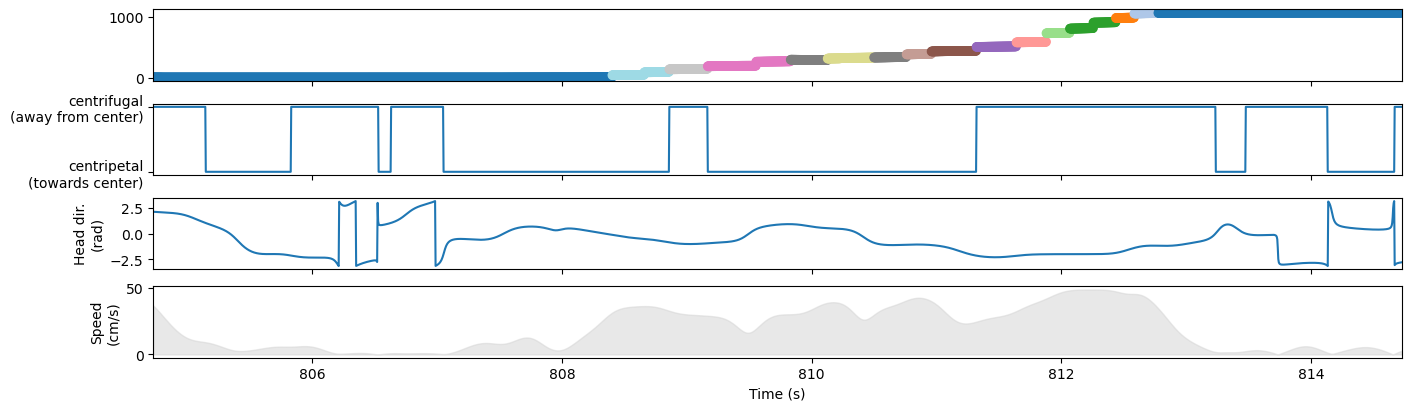

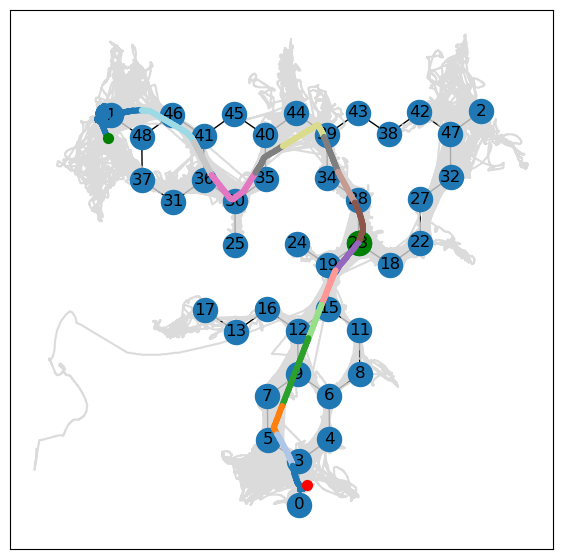

In [13]:
time_slice = slice(200_500, 203_000)
plot_centrifugal(
    time_slice,
    position_info,
    linear_position_info,
    is_centrifugal,
    track_graph,
    node_positions,
    center_node,
)

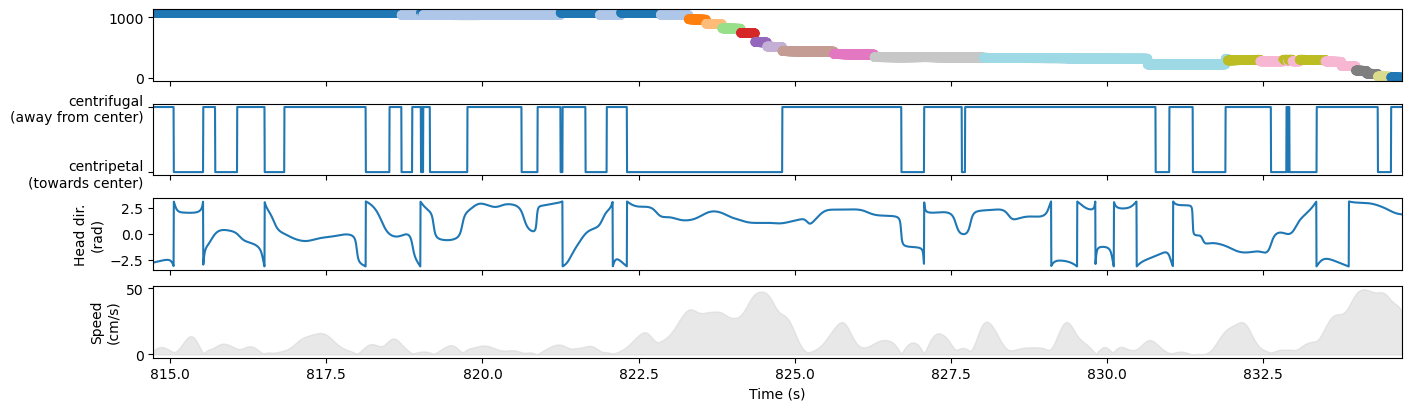

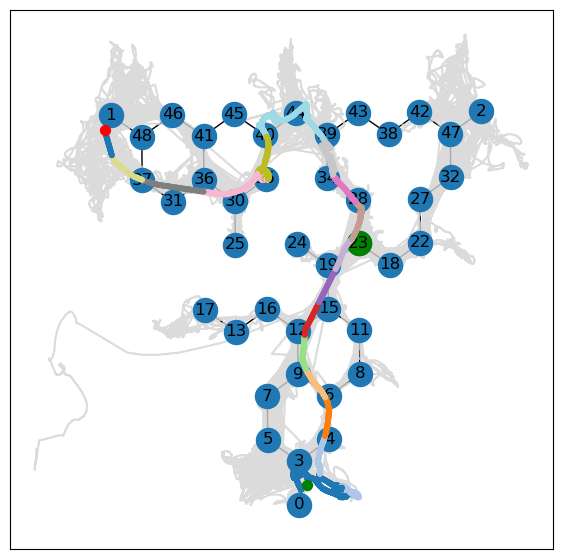

In [14]:
time_slice = slice(203_000, 208_000)
plot_centrifugal(
    time_slice,
    position_info,
    linear_position_info,
    is_centrifugal,
    track_graph,
    node_positions,
    center_node,
)

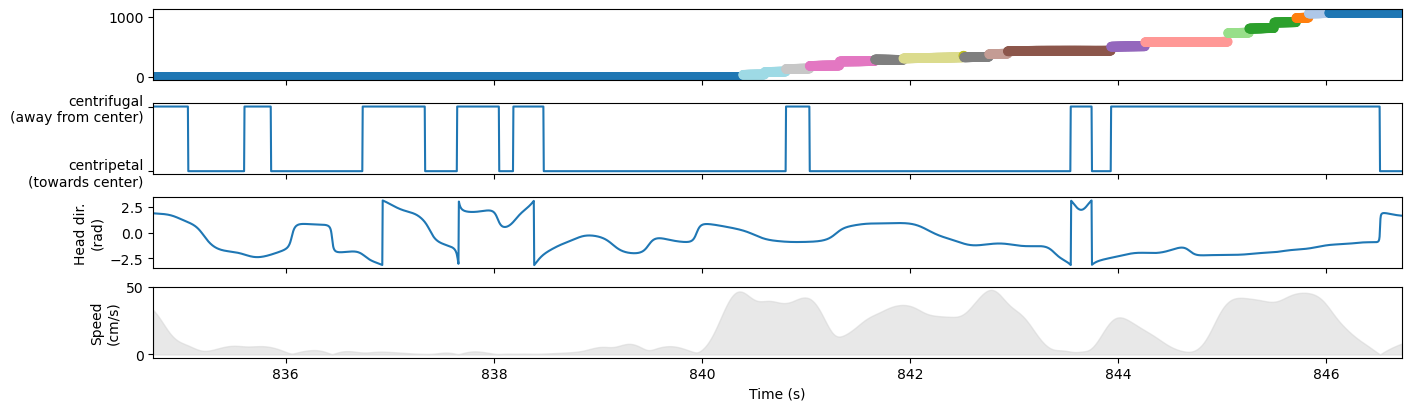

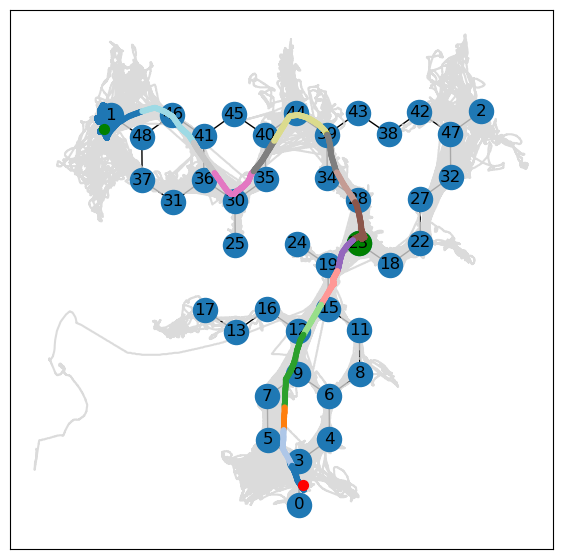

In [15]:
time_slice = slice(208_000, 211_000)
plot_centrifugal(
    time_slice,
    position_info,
    linear_position_info,
    is_centrifugal,
    track_graph,
    node_positions,
    center_node,
)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
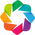

Launching server at http://localhost:64917


In [16]:
import holoviews as hv
import panel as pn
from holoviews.operation.datashader import rasterize

hv.extension("bokeh")
pn.extension()

height = 400
width = 500
sampling_frequency = 250

xlim = position_info.x.min() - 10, position_info.x.max() + 10
ylim = position_info.y.min() - 10, position_info.y.max() + 10
n_time = len(position_info)

# Rasterize the background plot for better performance
background = hv.Curve(position_info, kdims="x", vdims="y").opts(
    xlim=xlim,
    ylim=ylim,
    color="grey",
)
center_node_point = hv.Points([node_positions[center_node]], vdims=["x", "y"]).opts(
    color="green", size=10
)
rasterized_background = rasterize(background)


def get_plot(n):
    point = hv.Scatter(position_info.iloc[[n]], kdims="x", vdims="y").opts(
        size=10, color="magenta", width=width, height=height
    )
    # Calculate the end point of the head direction line
    radius = 4
    x_start = position_info.iloc[n].x
    y_start = position_info.iloc[n].y
    direction = position_info.iloc[n].head_direction
    x_end = x_start + radius * np.cos(direction)
    y_end = y_start + radius * np.sin(direction)

    head_direction_line = hv.Segments(
        [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
    ).opts(color="magenta", line_width=2, tools=["hover"])

    return point * head_direction_line


# Function to get the dynamic window plot
def get_centrifugal_plot(n):
    # Determine the window of points to display
    start_idx = max(0, n - 100)
    end_idx = min(n_time, n + 100)
    window = is_centrifugal[start_idx:end_idx].astype(float)

    line = hv.Curve(
        (np.arange(start_idx - n, end_idx - n) / sampling_frequency, window),
        kdims="time relative to current (s)",
        vdims="is centrifugal",
    ).opts(
        color="black",
        width=width,
        height=int(height / 3),
        ylim=(-0.3, 1.3),
        xlim=(-0.4, 0.4),
    )

    return line


# Dynamic map linked to the slider
slider = pn.widgets.IntSlider(start=0, end=n_time - 1, value=0, name="Time")
player = pn.widgets.Player(start=0, end=n_time - 1, value=0, interval=33, name="Time")

dynamic_point = hv.DynamicMap(pn.bind(get_plot, slider))

label_0 = hv.Text(0, -0.1, "centripidal (towards center)").opts(
    text_align="left", color="red"
)
label_1 = hv.Text(0, 1.1, "centrifugal (away from center)").opts(
    text_align="left", color="red"
)
zero_line = hv.Curve(([0, 0], [0, 1])).opts(color="red", line_dash="dotted")
centrifugal_line = (
    hv.DynamicMap(pn.bind(get_centrifugal_plot, slider)) * label_0 * label_1 * zero_line
)

# Link the player to the slider
player.jslink(slider, value="value")

# Combine the static background with the dynamic point
position_plot = rasterized_background * center_node_point * dynamic_point

# Layout the components using Panel
layout = pn.Column(
    slider,
    position_plot,
    centrifugal_line,
    player,
)

# Serve the application
layout.servable()
layout.show()

In [17]:
import numpy as np
import xarray as xr
from replay_trajectory_classification import Environment


def get_centers(bin_edges: np.ndarray) -> np.ndarray:
    return bin_edges[:-1] + np.diff(bin_edges) / 2


def simulate_posterior(position_info):
    env = Environment(place_bin_size=3.0).fit_place_grid(
        position_info[["x", "y"]].to_numpy()
    )

    n_time = len(position_info)
    time = position_info.index.to_numpy()
    # Create a grid for x and y positions
    x = get_centers(env.edges_[0])
    y = get_centers(env.edges_[1])
    x_grid = env.place_bin_centers_[:, 0].reshape(env.centers_shape_, order="F")
    y_grid = env.place_bin_centers_[:, 1].reshape(env.centers_shape_, order="F")

    # Generate a growing Gaussian distribution over time
    posterior_data = np.zeros((n_time, env.centers_shape_[0], env.centers_shape_[1]))
    mean_x = position_info["x"].mean()
    mean_y = position_info["y"].mean()

    for t in range(n_time):

        std_dev = 1 + 0.00001 * t  # Growing standard deviation over time
        gaussian = np.exp(
            -(((x_grid - mean_x) ** 2 + (y_grid - mean_y) ** 2) / (2 * std_dev**2))
        )
        gaussian[~env.is_track_interior_] = np.nan
        posterior_data[t, :, :] = gaussian / np.nansum(
            gaussian
        )  # Normalize to make it a probability distribution

    return xr.DataArray(
        posterior_data, coords=[time, x, y], dims=["time", "x_position", "y_position"]
    )


posterior = simulate_posterior(position_info)
posterior

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


<xarray.DataArray (time: 1613517, x_position: 48, y_position: 41)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time        (time) float64 2.728 2.732 2.736 ... 6.457e+03 6.457e+03
  * x_position  (x_position) float64 26.95 29.89 32.83 ... 159.3 162.2 165.2
  * y_position  (y_position) float64 -1.463 1.463 4.389 ... 109.7 112.6 115.6

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
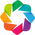

Launching server at http://localhost:64933


In [18]:
import holoviews as hv
import panel as pn
from holoviews.operation.datashader import datashade, rasterize
from holoviews.streams import RangeX
import xarray as xr

hv.extension("bokeh")
pn.extension()

# posterior = xr.DataArray(
#     np.random.rand(len(position_info), 50, 50),
#     dims=["time", "x_position", "y_position"],
# )

xlim = position_info.x.min() - 10, position_info.x.max() + 10
ylim = position_info.y.min() - 10, position_info.y.max() + 10
n_time = len(position_info)

width, height = 800, 600  # Adjust as needed


def get_maze_background(position_info):
    # Define points for all positions
    all_positions = hv.Points(
        (position_info["x"], position_info["y"]),
        kdims=["x", "y"],
    )

    # Rasterize the points and set color to grey
    return datashade(all_positions, cmap=["grey"])


def get_animal_position_dot(time_ind):
    point = hv.Scatter(position_info.iloc[[time_ind]], kdims="x", vdims="y").opts(
        size=10, color="magenta", width=width, height=height
    )
    # Calculate the end point of the head direction line
    radius = 4
    x_start = position_info.iloc[time_ind].x
    y_start = position_info.iloc[time_ind].y
    direction = position_info.iloc[time_ind].head_direction
    x_end = x_start + radius * np.cos(direction)
    y_end = y_start + radius * np.sin(direction)

    head_direction_line = hv.Segments(
        [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
    ).opts(color="magenta", line_width=2, tools=["hover"])

    return point * head_direction_line


def get_posterior_quadmesh(time_ind):
    posterior_slice = posterior.isel(time=time_ind)
    quadmesh = hv.QuadMesh(
        posterior_slice,
        kdims=["x_position", "y_position"],
        vdims=["probability"],
    ).opts(cmap="viridis", alpha=1.0, width=width, height=height)
    return quadmesh


# Dynamic map linked to the player
player = pn.widgets.Player(start=0, end=n_time - 1, value=0, interval=33, name="Time")
animal_position = hv.DynamicMap(pn.bind(get_animal_position_dot, player))
posterior_image = hv.DynamicMap(pn.bind(get_posterior_quadmesh, player))


# Slider to control the speed of the player (interval)
speed_slider = pn.widgets.IntSlider(
    name="Speed (ms/frame)", start=1, end=1000, value=100, step=10
)
# Link the slider to the interval property of the player
pn.bind(player.param.interval, speed_slider)


# Update the player's interval property based on the slider's value
def update_interval(event):
    player.interval = event.new


speed_slider.param.watch(update_interval, "value")

# Dropdown to control the speed of the player (interval)
speed_options = {
    "1/8x": 8,
    "1/4x": 4,
    "1/2x": 2,
    "1x": 1,
    "2x": 0.5,
    "4x": 0.25,
    "8x": 0.125,
}
speed_dropdown = pn.widgets.Select(
    name="Playback Speed", options=speed_options, value=1
)

base_interval = 4  # ms/frame


# Update the player's interval property based on the dropdown's value
def update_interval(event):
    player.interval = int(event.new * base_interval)


speed_dropdown.param.watch(update_interval, "value")

maze_background = get_maze_background(position_info).opts(xlim=xlim, ylim=ylim)
# Combine the static background with the dynamic point
position_plot = posterior_image * animal_position

# Layout the components using Panel
layout = pn.Column(position_plot, pn.Row(player, speed_dropdown))

# Serve the application
layout.servable()
layout.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
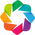

Launching server at http://localhost:64937


In [19]:
import holoviews as hv
import panel as pn
from holoviews.operation.datashader import datashade, rasterize
from holoviews.streams import RangeX
import xarray as xr

hv.extension("bokeh")
pn.extension()

# posterior = xr.DataArray(
#     np.random.rand(len(position_info), 50, 50),
#     dims=["time", "x_position", "y_position"],
# )

xlim = position_info.x.min() - 10, position_info.x.max() + 10
ylim = position_info.y.min() - 10, position_info.y.max() + 10
n_time = len(position_info)

width, height = 800, 600  # Adjust as needed


def get_animal_position_dot(time_ind):
    point = hv.Scatter(position_info.iloc[[time_ind]], kdims="x", vdims="y").opts(
        size=10, color="magenta", width=width, height=height
    )
    # Calculate the end point of the head direction line
    radius = 4
    x_start = position_info.iloc[time_ind].x
    y_start = position_info.iloc[time_ind].y
    direction = position_info.iloc[time_ind].head_direction
    x_end = x_start + radius * np.cos(direction)
    y_end = y_start + radius * np.sin(direction)

    head_direction_line = hv.Segments(
        [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
    ).opts(color="magenta", line_width=2, tools=["hover"])

    return point * head_direction_line


def get_posterior_quadmesh(time_ind):
    posterior_slice = posterior.isel(time=time_ind)
    return hv.QuadMesh(
        posterior_slice,
        kdims=["x_position", "y_position"],
        vdims=["probability"],
    ).opts(cmap="viridis", alpha=1.0, width=width, height=height)


max_rate = multiunit_firing_rate.to_numpy().max()


def create_scrolling_line_plot(
    data,
    ylabel,
    ylim,
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=250,
    width=800,
    height=600,
):
    n_time = len(data)
    n_samples = int((window_lim[1] - window_lim[0]) * sampling_frequency)
    half_samples = n_samples // 2

    def plot_func(n):
        start_idx = max(0, n - half_samples)
        end_idx = min(n_time, n + half_samples)
        window = np.asarray(data, dtype=float)[start_idx:end_idx].squeeze()
        line = hv.Curve(
            (np.arange(start_idx - n, end_idx - n) / sampling_frequency, window),
            kdims="time relative to current (s)",
            vdims=ylabel,
        ).opts(
            color="black",
            width=width,
            height=int(height / height_factor),
            ylim=ylim,
            xlim=window_lim,
        )
        return line

    return hv.DynamicMap(pn.bind(plot_func, player))


def create_playback_speed_dropdown(player, sampling_frequency=250):
    # Dropdown to control the speed of the player (interval)
    speed_options = {
        "1/8x": 8,
        "1/4x": 4,
        "1/2x": 2,
        "1x": 1,
        "2x": 0.5,
        "4x": 0.25,
        "8x": 0.125,
    }
    speed_dropdown = pn.widgets.Select(
        name="Playback Speed", options=speed_options, value=1
    )
    base_interval = 1000 / sampling_frequency  # ms/frame

    # Update the player's interval property based on the dropdown's value
    def update_interval(event):
        player.interval = int(event.new * base_interval)

    speed_dropdown.param.watch(update_interval, "value")

    return speed_dropdown


# Dynamic map linked to the player
player = pn.widgets.Player(start=0, end=n_time - 1, value=0, interval=33, name="Time")
animal_position = hv.DynamicMap(pn.bind(get_animal_position_dot, player))
posterior_image = hv.DynamicMap(pn.bind(get_posterior_quadmesh, player))

multiunit_plot = create_scrolling_line_plot(
    multiunit_firing_rate,
    "Rate (spikes/s)",
    (0, multiunit_firing_rate.to_numpy().max()),
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)
speed_plot = create_scrolling_line_plot(
    position_info["speed"],
    "Speed (cm/s)",
    (0, 100),
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)
head_direction_plot = create_scrolling_line_plot(
    position_info["head_direction"],
    "Head direction (rad)",
    (-np.pi, np.pi),
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)
speed_dropdown = create_playback_speed_dropdown(player, sampling_frequency=sampling_frequency)

# Combine the static background with the dynamic point
position_plot = posterior_image * animal_position

# Layout the components using Panel
layout = pn.Row(
    pn.Column(position_plot, pn.Row(player, speed_dropdown)),
    pn.Column(multiunit_plot, speed_plot, head_direction_plot),
)

# Serve the application
layout.servable()
layout.show()

In [20]:
import holoviews as hv
import panel as pn
import numpy as np


def create_2D_decoding_plot(
    position_info,
    posterior,
    sampling_frequency=250,
    width=800,
    height=600,
    head_dir_radius=4,
):
    n_time = len(posterior.time)

    def get_animal_position_dot(time_ind):
        point = hv.Scatter(position_info.iloc[[time_ind]], kdims="x", vdims="y").opts(
            size=10, color="magenta", width=width, height=height
        )
        # Calculate the end point of the head direction line
        x_start = position_info.iloc[time_ind].x
        y_start = position_info.iloc[time_ind].y
        direction = position_info.iloc[time_ind].head_direction
        x_end = x_start + head_dir_radius * np.cos(direction)
        y_end = y_start + head_dir_radius * np.sin(direction)

        head_direction_line = hv.Segments(
            [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
        ).opts(color="magenta", line_width=2, tools=["hover"])

        return point * head_direction_line

    def get_posterior_quadmesh(time_ind):
        posterior_slice = posterior.isel(time=time_ind)
        return hv.QuadMesh(
            posterior_slice,
            kdims=["x_position", "y_position"],
            vdims=["probability"],
        ).opts(cmap="viridis", alpha=1.0, width=width, height=height)

    # Create player controls
    player = create_player(n_time, sampling_frequency=sampling_frequency)
    playback_speed_dropdown = create_playback_speed_dropdown(
        player, sampling_frequency=sampling_frequency
    )

    posterior_image = hv.DynamicMap(pn.bind(get_posterior_quadmesh, player))
    animal_position = hv.DynamicMap(pn.bind(get_animal_position_dot, player))

    # Overlay the animal position on the posterior
    decode_plot = pn.Column(
        posterior_image * animal_position, pn.Row(player, playback_speed_dropdown)
    )

    return decode_plot, player


def create_scrolling_line_plot(
    data,
    ylabel,
    ylim,
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=250,
    width=800,
    height=600,
):
    n_time = len(data)
    n_samples = int((window_lim[1] - window_lim[0]) * sampling_frequency)
    half_samples = n_samples // 2

    def plot_func(n):
        start_idx = max(0, n - half_samples)
        end_idx = min(n_time, n + half_samples)
        window = np.asarray(data, dtype=float)[start_idx:end_idx].squeeze()
        line = hv.Curve(
            (np.arange(start_idx - n, end_idx - n) / sampling_frequency, window),
            kdims="time relative to current (s)",
            vdims=ylabel,
        ).opts(
            color="black",
            width=width,
            height=int(height / height_factor),
            ylim=ylim,
            xlim=window_lim,
        )
        return line

    return hv.DynamicMap(pn.bind(plot_func, player))


def create_player(n_time, sampling_frequency=250):
    base_interval = int(1000 / sampling_frequency)  # ms/frame
    player = pn.widgets.Player(
        start=0, end=n_time - 1, value=0, interval=base_interval, name="Time"
    )
    return player


def create_playback_speed_dropdown(player, sampling_frequency=250):
    # Dropdown to control the speed of the player (interval)
    speed_options = {
        "1/8x": 8,
        "1/4x": 4,
        "1/2x": 2,
        "1x": 1,
        "2x": 0.5,
        "4x": 0.25,
        "8x": 0.125,
    }
    speed_dropdown = pn.widgets.Select(
        name="Playback Speed", options=speed_options, value=1
    )
    base_interval = 1000 / sampling_frequency  # ms/frame

    # Update the player's interval property based on the dropdown's value
    def update_interval(event):
        player.interval = int(event.new * base_interval)

    speed_dropdown.param.watch(update_interval, "value")

    return speed_dropdown

## Create the decoding plot
sampling_frequency = 250
width = 800
height = 600
window_lim = (-0.4, 0.4)

decode_plot, player = create_2D_decoding_plot(
    position_info,
    posterior,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
    head_dir_radius=4,
)

multiunit_plot = create_scrolling_line_plot(
    multiunit_firing_rate,
    "Rate (spikes/s)",
    (0, multiunit_firing_rate.to_numpy().max()),
    player,
    window_lim=window_lim,
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)
speed_plot = create_scrolling_line_plot(
    position_info["speed"],
    "Speed (cm/s)",
    (0, 100),
    player,
    window_lim=window_lim,
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)
head_direction_plot = create_scrolling_line_plot(
    position_info["head_direction"],
    "Head direction (rad)",
    (-np.pi, np.pi),
    player,
    window_lim=window_lim,
    height_factor=3,
    sampling_frequency=sampling_frequency,
    width=width,
    height=height,
)

# Layout the components using Panel
layout = pn.Row(
    decode_plot,
    pn.Column(multiunit_plot, speed_plot, head_direction_plot),
)

# Serve the application
layout.servable()
layout.show()

Launching server at http://localhost:64941
